# A/B-тестирование нововведений в рекомендательную систему

**Цель исследования** — провести оценку результатов A/B-теста и корректность его проведения в соответствии с техническим заданием.

**Ход исследования**

Данные представлены в виде нескольких таблиц, содержащих список новых пользователей и информацию об их действиях, а также вспомогательную информацию - список участников всех тестов и календарь маркетинговых событий. Необходимо провести обзор и предобработку данных - обработать возможные дубликаты и пропуски, при необходимости поменять тип данных и создать дополнительные столбцы. Затем будет проведена оценка коррекности проведения теста - данные будут сверены с требованиями технического задания и календарём маркетинговых активностей. После будет проведён исследовательский анализ данных, в ходе которого будет изучено распределение данных и конверсия воронки событий, а последним этапом станет анализ результатов проведённого теста. По результатам исследования будет сформирован общий вывод.

Таким образом, исследование будет разделено на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
2. [**Иследовательский анализ данных**](#2)
3. [**Анализ результатов тестирования**](#3)
4. [**Общий вывод**](#4)
___

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<a id='1'></a>
## Обзор и предобработка данных
Сначали импортируем все необходимые таблицы с данными и рассмотрим каждую по отдельности.

In [1]:
# импортируем библиотеки для работы с данными

import os
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.io as pio

# настройки отображения и рабочей среды

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
sns.set_style('darkgrid')
sns.set(font_scale = 2)
pio.renderers.default = "svg"
plt.rcParams.update({'axes.labelsize': 15,'axes.titlesize': 25})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

In [2]:
# загружаем данные

users = pd.read_csv('final_ab_new_users.csv') # новые пользователи
user_events = pd.read_csv('final_ab_events.csv') # действия новых пользователей
test_participants = pd.read_csv('final_ab_participants.csv') # список участников разных AB тестов
marketing_events = pd.read_csv('ab_project_marketing_events.csv') # календарь маркетинговых событий

### Новые пользователи

In [3]:
def overview(df):
    
    '''функция для вывода общей информации, 
       описательной статистики и нескольких случайных строк'''
    
    df.info()
    display(
        df.describe(include='all', datetime_is_numeric=True), 
        df.sample(5, random_state=0)
    )
    if df.isna().sum().sum() > 0:
        print('missing values count')
        print('')
        print(df.isna().sum())

# таблица с пользователями    
    
overview(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


,user_id,first_date,region,device
9145,8C07103A3DCCA5CB,2020-12-14,EU,Android
33709,9A7EB0465E2DC590,2020-12-10,CIS,Android
7768,1D400F27F375EDDC,2020-12-14,CIS,PC
54387,006E3D14743030D4,2020-12-13,EU,Android
10017,9A79AAC8B0EA52AE,2020-12-14,EU,Mac


___
Таблица содержит 61,733 строку и 4 столбца, явные пропуски отсутствуют.

Описание данных из документации:

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура таблицы:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.
___

Дата регистрации представлены в виде текста, для корректных расчётов необходимо преобразование:

In [4]:
# меняем тип данных

users['first_date'] = pd.to_datetime(users['first_date'])

Из описательной статистики таблицы видно, что все пользователи уникальны. Посмотрим на значения остальных столцов:
<a id='dates'></a>

In [5]:
# посмотрим на даты регистрации

users['first_date'].value_counts()

2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
2020-12-12    3963
2020-12-19    3617
2020-12-18    3365
2020-12-08    3239
2020-12-22    3083
2020-12-10    3076
2020-12-17    3048
2020-12-15    3043
2020-12-11    2390
2020-12-23    2180
2020-12-16    2110
2020-12-09    2101
Name: first_date, dtype: int64

- Абсолютное большинство пользователей зарегестрировались в последний день рассматриваемого периода.

Согласно техническому заданию, набор пользователей для теста был закончен 21 декабря - ограничим данные этой датой:

In [6]:
users = users.query('first_date <= "2020-12-21"')

In [7]:
# посмотрим на регионы

users['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

- В данных присутствуют пользователи из четырёх регионов, большая часть представляет регион `EU`

In [8]:
# посмотрим на пользовательские устройства

users['device'].value_counts()

Android    25161
PC         14310
iPhone     11477
Mac         5522
Name: device, dtype: int64

- Подавляющее больщинство пользователей используют устройство на базе `Android`

### Действия новых пользователей

In [9]:
# таблица с логами пользовательских событий

overview(user_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
count,440317,440317,440317,"62,740.00"
unique,58703,267268,4,NaN
top,A3917F81482141F2,2020-12-23 02:37:24,login,NaN
freq,36,10,189552,NaN
mean,NaN,NaN,NaN,23.88
std,NaN,NaN,NaN,72.18
min,NaN,NaN,NaN,4.99
25%,NaN,NaN,NaN,4.99
50%,NaN,NaN,NaN,4.99
75%,NaN,NaN,NaN,9.99


,user_id,event_dt,event_name,details
390825,355E781F2D95012A,2020-12-22 16:15:15,login,NaN
82196,25CDE8C43F052564,2020-12-15 16:12:06,product_cart,NaN
211107,8857321F4D97B089,2020-12-22 15:56:32,product_page,NaN
182271,6F28139FA1E8EF98,2020-12-18 10:11:55,product_page,NaN
380348,CD104B18BF9D39BE,2020-12-21 21:02:39,login,NaN


missing values count

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


___
Таблица содержит 440,317 строк и 4 столбца. Явные пропуски наблюдаются только в столбце `details`.

Описание данных согласно документации:

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура таблицы:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.
____

- Количество уникальных пользователей таблицы с пользовательскими событиями (*58,703*) не совпадает с количеством из таблицы со всеми новыми пользователями (*61,733*) - это указывает на то, что часть пользователей не совершали никаких активностей, что должно быть учтено при анализе результатов теста.

Даты в этой таблице также представлены в виде текста, сделаем преобразование:

In [10]:
# меняем тип данных

user_events['event_dt'] = pd.to_datetime(user_events['event_dt'])

Изучим уникальные типы событий:

In [11]:
# смотрим уникальные значения

user_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

- Логи пользовательских событий содержат четыре уникальных значения - `login` (*вход в учётную запись*), `product_page` (*просмотр страницы с товаром*), `product_cart` (*просмотр страницы с корзиной товаров*) и `purchase` (*успешная покупка*). Причём количество событий с покупкой больше, чем количество просмотров корзины, что может сигнализировать об использовании модулей вроде `покупка в один клик`.

На этапе исследовательского анализа данных этот момент будет изучен подробнее с помощью воронки конверсии. 

Дальше попробуем найти закономерность в пропущенных значениях - в документации приведён пример с указанием суммы покупки в столбце `details` для события `purchase`. Проверим, какие ещё могут быть варианты:

In [12]:
# посмотрим на значения `details` (кроме примера из документации)

(
    user_events[user_events['details'].notna()]
    .query('event_name != "purchase"')
)

,user_id,event_dt,event_name,details


Учитывая результаты проверки и числовой формат столбца можем сделать вывод, что столбец `details` используются исключительно для указания суммы покупки. Так как суммы выручки не является одной из целевых метрик для A/B-теста, вместо обработки пропусков мы можем удалить столбец целиком:

In [13]:
user_events.dropna(axis=1, inplace=True)

### Список участников разных A/B-тестов

In [14]:
# список пользователей - участников A/B-тестирования

overview(test_participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


,user_id,group,ab_test
4890,9708BA96BC78EE9F,A,recommender_system_test
9825,6D05D44AB00C84D2,B,interface_eu_test
6727,97248D21983C5DBC,B,interface_eu_test
624,92F843D598252571,A,recommender_system_test
15137,CDB54E138640B8EF,A,interface_eu_test


___
Таблица содержит 18,268 строк и 3 столбца. Явные пропуски отсутствуют. 

Описание данных согласно документации:

`final_ab_participants.csv` — таблица участников тестов.

Структура таблицы:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.
___

Согласно техническому задания, целевая аудитория теста - 15% новых пользователей из региона `EU`. Проверим данные таблицы на соответствие этому требованию:

In [15]:
# посмотрим на распределение пользователей по регионам

test_users = list(
    test_participants
    .query('ab_test == "recommender_system_test"')["user_id"]
)


region_distribution = (
    users
    .query('user_id in @test_users')['region']
    .value_counts()
    .to_frame()
    .merge(
        users['region']
        .value_counts()
        .to_frame(),
        left_index=True,
        right_index=True)
    .rename(columns={'region_x':'test',
                     'region_y':'total'})
    .reindex(columns=['total', 'test'])
)

region_distribution['test'] = (
    round(
        region_distribution['test']/
        region_distribution['total']*100, 2)
    .astype(str) + '%'
)

region_distribution

,total,test
EU,42340,15.0%
N.America,8347,2.67%
APAC,2883,2.5%
CIS,2900,1.9%


- Требование технического задания в формировании целовой аудитории теста из 15% пользователей из региона `EU` соблюдено

В тест также попала часть пользователей из других регионов - удалим их для корректной оценки результатов теста:

In [16]:
users = users.query('region == "EU"')

В таблице можно увидеть данные пользователей двух разных тестирований - `recommender_system_test` и `interface_eu_test`. Целью исследования является анализ результатов только первого теста, но сначала необходимо проверить данные на отсутствие пересечений - количество уникальных идентификаторов пользователей не совпадает с числом строк, что указывает на наличие дубликатов.

In [17]:
# проверим на явные дубликаты

print(f' Задублированных строк - {test_participants.duplicated().sum()}')

# проверим, что нет пользователей, попавших в оба теста

inter = np.intersect1d(
    test_participants.query('ab_test == "recommender_system_test"')['user_id'].unique(),
    test_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()
)
print(f' Уникальных пользователей, попавших в оба теста - {inter.size}')

 Задублированных строк - 0
 Уникальных пользователей, попавших в оба теста - 1602


Явных дубликатов не выявлено, а вот пересечений довольно много - 1,602 уникальных пользователей являлись участниками двух разных тестирований. В таком случае анализировать влияние новвоведений на пользовательское поведение будет неккоректно, так как группы будет невозможно отличить. Очистим данные от пользователей, попавших в группу `B` конкурирующего теста:

In [18]:
# проверим пересечение с группой B конкурирующего теста

inter = np.intersect1d(
    test_participants.query('ab_test == "recommender_system_test"')['user_id'].unique(),
    test_participants.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique()
)
print(f' Уникальных пользователей, попавших в эксперементальную группу другого теста - {inter.size}')

 Уникальных пользователей, попавших в эксперементальную группу другого теста - 783


In [19]:
# убираем ошибочные данные

test_participants = (
    test_participants[
        ~test_participants['user_id']
        .isin(inter)]
)

# оставляем только данные целевого теста

test_participants = (
    test_participants
    .query('ab_test == "recommender_system_test"')
)

Теперь таким же образом проверим, что одни и те же пользователи не попадают в разные группы тестирования:

In [20]:
# проверим, что нет пользователей, попавших в обе группы

inter = np.intersect1d(
    test_participants.query('group == "A"')['user_id'].unique(),
    test_participants.query('group == "B"')['user_id'].unique()
)
print(f' Уникальных пользователей, попавших в обе группы - {inter.size}')

 Уникальных пользователей, попавших в обе группы - 0


Посмотрим на данные ещё раз:

In [21]:
overview(test_participants)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5918 non-null   object
 1   group    5918 non-null   object
 2   ab_test  5918 non-null   object
dtypes: object(3)
memory usage: 184.9+ KB


,user_id,group,ab_test
count,5918,5918,5918
unique,5918,2,1
top,D1ABA3E2887B6A73,A,recommender_system_test
freq,1,3385,5918


,user_id,group,ab_test
1601,AF2E9FDAF45DB4F2,A,recommender_system_test
6294,D6605910D68C12E0,B,recommender_system_test
3128,1644E1D5507A64A6,A,recommender_system_test
2106,5FF8B6AB257B404F,B,recommender_system_test
847,B255F022EA9889B7,B,recommender_system_test


- Пользователи неравномерно распределены по группам - из 5,918 уникальных пользователей 3,385 находятся в группе `A`, что составляет примерно 57%.


- Целевой показатель количества участников в 6,000 формально был достигнут, но из-за пересечений с другим тестом часть данных не подлежит анализу, а их вынужденное удаление может негативно отразиться на выводах из анализа итоговых результатов. 

### Календарь маркетинговых событий

In [22]:
# таблица с маркетинговыми активностями

overview(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


,name,regions,start_dt,finish_dt
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


___
Таблица содержит 14 строк и 4 столбца. Явные пропуски отсутствуют.

Описание данных согласно документации:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура таблицы:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.
___

Преобразуем данные и проверим, имеются ли в наличии компании, пересекающиеся с регистрацией новых пользователей:

In [23]:
# преобразовываем даты

marketing_events['start_dt'] = (
    pd.to_datetime(marketing_events['finish_dt'])
)
marketing_events['finish_dt'] = (
    pd.to_datetime(marketing_events['finish_dt'])
)

# посмотрим компании декабря и января

interscecting_marketing = marketing_events[
    (marketing_events['start_dt'].dt.month.isin([1, 12]))|
    (marketing_events['finish_dt'].dt.month.isin([1, 12]))
]

interscecting_marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2021-01-03,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-12-01,2020-12-01
10,CIS New Year Gift Lottery,CIS,2021-01-07,2021-01-07


- Маркетинговая компании `Christmas&New Year Promo` пересекается с датами проведения A/B-тестирования, что может повлиять на пользовательское поведение и исказить вывода анализа результатов теста.

Остальные компании либо не совпадают по датам, либо не имеют отношение к региону `EU`.

### Выводы

Данные всех четырёх таблиц были предобработаны - преобразованы даты, обработаны пропущенные значения. Было проверено соответствие данных техническому заданию A/B-тестирования.

При работе с данными были сделаны следующие выводы:

- Абсолютное большинство пользователей зарегестрировались в последний день рассматриваемого периода.


- В данных присутствуют пользователи из четырёх регионов, большая часть представляет регион `EU`


- Подавляющее больщинство пользователей используют устройство на базе `Android`


- Количество уникальных пользователей таблицы с пользовательскими событиями (*58,703*) не совпадает с количеством из таблицы со всеми новыми пользователями (*61,733*) - это указывает на то, что часть пользователей не совершали никаких активностей, что должно быть учтено при анализе результатов теста.


- Логи пользовательских событий содержат четыре уникальных значения - `login` (*вход в учётную запись*), `product_page` (*просмотр страницы с товаром*), `product_cart` (*просмотр страницы с корзиной товаров*) и `purchase` (*успешная покупка*). Причём количество событий с покупкой больше, чем количество просмотров корзины, что может сигнализировать об использовании модулей вроде `покупка в один клик`.


- Пользователи неравномерно распределены по группам - из 5,918 уникальных пользователей 3,385 находятся в группе `A`, что составляет примерно 57%.


- Целевой показатель количества участников в 6,000 формально был достигнут, но из-за пересечений с другим тестом часть данных не подлежит анализу, а их вынужденное удаление может негативно отразиться на выводах из анализа итоговых результатов. 


- Требование технического задания в формировании целовой аудитории теста из 15% пользователей из региона `EU` соблюдено, но в тест также попала часть пользователей из других регионов.


- Маркетинговая компании `Christmas&New Year Promo` пересекается с датами проведения A/B-тестирования, что может повлиять на пользовательское поведение и исказить вывода анализа результатов теста.

<a id='2'></a>
## Исследовательский анализ данных

Исследовательский анализ разделён на два шага:
- [**Анализ распределения данных**](#2.1)
- [**Воронка пользовательских событий**](#2.2)

<a id='2.1'></a>
### Анализ распределения данных
Начнём с группировки необходимых данных из таблиц:

In [24]:
test_participants.info()
user_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5918 non-null   object
 1   group    5918 non-null   object
 2   ab_test  5918 non-null   object
dtypes: object(3)
memory usage: 184.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 10.1+ MB


In [25]:
# объединяем данные

data = (
    test_participants
    .merge(
        users, left_on='user_id',
        right_on='user_id',
        how='left')
    .merge(
        user_events, left_on='user_id',
        right_on='user_id',
        how='left')
    .drop(columns=['ab_test', 'device'])
    .rename(columns={'first_date':'registration'})
)

# выводим результат

overview(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24516 entries, 0 to 24515
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       24516 non-null  object        
 1   group         24516 non-null  object        
 2   registration  23082 non-null  datetime64[ns]
 3   region        23082 non-null  object        
 4   event_dt      21842 non-null  datetime64[ns]
 5   event_name    21842 non-null  object        
dtypes: datetime64[ns](2), object(4)
memory usage: 1.3+ MB


,user_id,group,registration,region,event_dt,event_name
count,24516,24516,23082,23082,21842,21842
unique,5918,2,NaN,1,NaN,4
top,1198061F6AF34B7B,A,NaN,EU,NaN,login
freq,28,18112,NaN,23082,NaN,9901
mean,NaN,NaN,2020-12-14 23:29:22.100337920,NaN,2020-12-18 23:44:45.625904128,NaN
min,NaN,NaN,2020-12-07 00:00:00,NaN,2020-12-07 00:05:57,NaN
25%,NaN,NaN,2020-12-12 00:00:00,NaN,2020-12-15 11:05:27.249999872,NaN
50%,NaN,NaN,2020-12-15 00:00:00,NaN,2020-12-19 11:52:24.500000,NaN
75%,NaN,NaN,2020-12-19 00:00:00,NaN,2020-12-22 15:11:55,NaN
max,NaN,NaN,2020-12-21 00:00:00,NaN,2020-12-30 12:42:57,NaN


,user_id,group,registration,region,event_dt,event_name
14690,E123EF1A9A7332A4,A,2020-12-09,EU,2020-12-10 02:11:09,login
10819,EBA69AB145E565D7,B,2020-12-15,EU,2020-12-16 00:12:10,purchase
3739,F7BAFF2E0A04F11B,A,2020-12-21,EU,2020-12-22 12:02:11,login
20409,35795D0E78C18AE4,A,2020-12-12,EU,2020-12-12 23:56:30,login
2291,831887FE7F2D6CBA,A,2020-12-07,EU,2020-12-09 02:19:17,purchase


missing values count

user_id            0
group              0
registration    1434
region          1434
event_dt        2674
event_name      2674
dtype: int64


В полученной таблице содержиться 24,516 записей и 6 столбцов.
___
Описательная статистика показывает несколько важных моментов:

- Пользовательские события распределены неравномерно - на группу `A` приходится 18,112 событий, что составляет около **74%**.


- Самое позднее событие приходится на 30-12-2020, за несколько дней до официального завершения теста - возможна серьёзная ошибка в формировании лога пользовательских событий. На временной период в текущей выборке не влияет ни одна из маркетинговых кампаний.


- Столбцы с датой и названием события содержат пропуски - это коррелируют с выводом об отсутствии активности у части пользователей, сделанным во время обзора сырых данных


Изучим распределение данных - посчитаем количество уникальных пользователей за каждый день (метрика DAU) и количество событий:

In [26]:
# сделаем копию датасета для eda

eda = data.copy()
eda['event_day'] = eda['event_dt'].dt.date

# считаем dau и количество событий

dau_events = (
    eda
    .pivot_table(index='event_day', 
                 values=('user_id', 'event_name'),
                 aggfunc={'user_id':'nunique', 'event_name':'count'}
                )
    .reset_index()
    .rename(columns={'event_day':'date',
                     'event_name':'events',
                     'user_id':'unique_users'}
           )
)

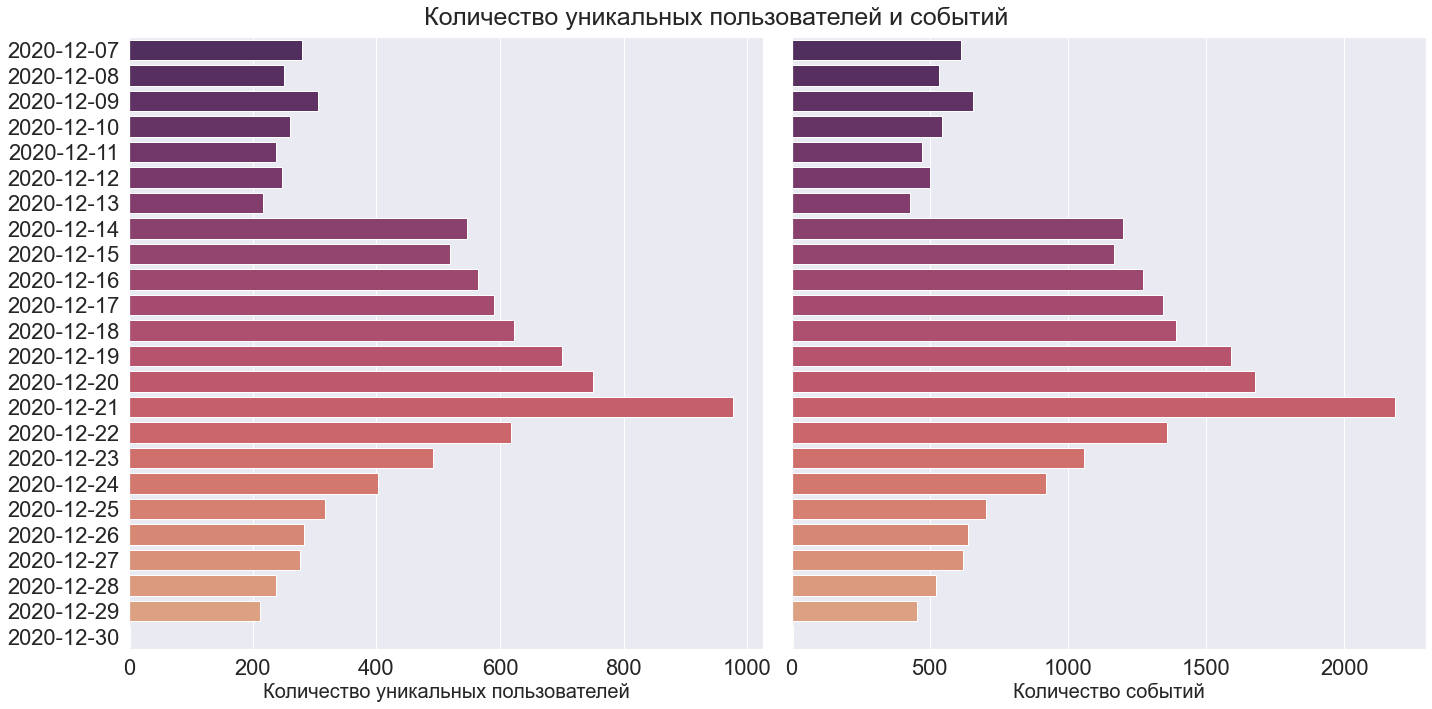

In [27]:
# визуализируем результат

def barp(par, ax):
    
    sns.barplot(data=dau_events,
                x=par, y='date', 
                ax=ax, palette='flare_r')

    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20, 10), sharey=True)

barp('unique_users', ax1)
barp('events', ax2)


ax1.set_yticklabels(dau_events['date'])
ax1.set_ylabel(None)
ax1.set_xlabel('Количество уникальных пользователей', fontsize=20)

ax2.set_ylabel(None)
ax2.set_xlabel('Количество событий', fontsize=20)


plt.suptitle('Количество уникальных пользователей и событий', fontsize=25)
plt.tight_layout()

plt.show()

- Распределение количества уникальных пользователей и событий ненормированно - 14-го декабря происходит аномальный скачок параметров, который достигает пика 21-го декабря, после чего происходит резкий спад. Фактической датой окончания теста можно считать 30-ое декабря - до официального прекращения проведения теста 4-го января в данных больше не наблюдается каких либо пользовательских событий.

Попробуем изучить подробнее аномальный скачок 14-го декабря:

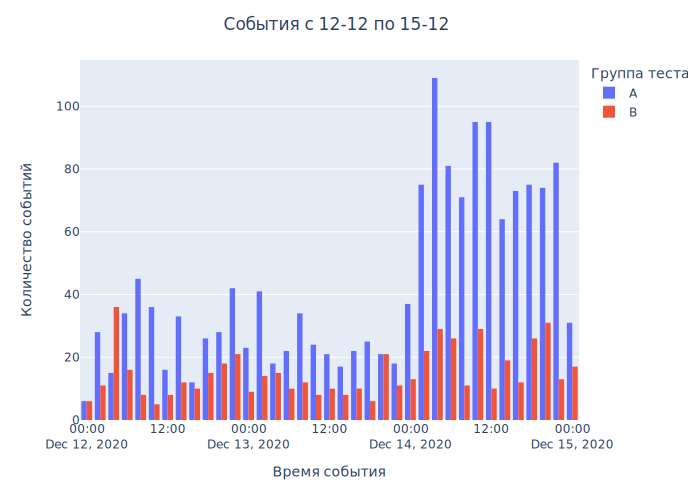

In [28]:
# визуализируем количество событий в разрезе групп теста

events = eda.query('20201212 <= event_dt <= 20201215')

labels = dict(
    event_dt = 'Время события',
    group = 'Группа теста',
    count = 'Количество событий'
)

fig = (
    px.histogram(events,x='event_dt', 
                 color='group', 
                 barmode='group',
                 labels=labels)
)

fig.update_yaxes(title='Количество событий')
fig.update_layout(title = 'События с 12-12 по 15-12', title_x= .48)

fig.show()

Аномальный скачок происходит в 01:30 14.12.2020, и касается только пользователей контрольной группы теста. В имеющихся данных отсутствуют рациональное объяснение для этого - в этот период не проводится никаких маркетинговых компаний, а даже если бы они были - влияние на пользователей было бы равным. Возможно ответ кроется в конверсии в событие, которая будет изучена на следующем этапе.

<a id='2.2'></a>
### Воронка пользовательских событий

Перейдём к анализу самих событий - посчитаем количество событий и пользователей, которые их совершают, а затем построим воронку

In [29]:
# группируем данные

events = (
    eda
    .pivot_table(index=('event_day','event_name'), 
                 values='user_id',
                 aggfunc=('count','nunique')
                )
    .reset_index()
    .rename(columns=dict(
        count = 'events',
        nunique='unique_users'))
    .sort_values('events', ascending=False)
)

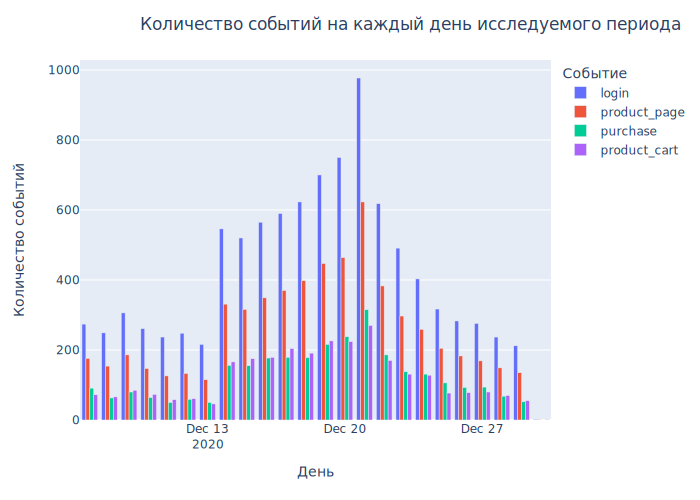

In [30]:
# визуализируем количество событий по типам

labels = dict(
    event_day = 'День',
    event_name = 'Событие',
    events = 'Количество событий'
)

fig = px.bar(
    events, x='event_day', 
    y='events', color='event_name', 
    barmode='group', labels=labels
)

fig.update_layout(title = 'Количество событий на каждый день исследуемого периода', title_x= .2)
fig.show()

В целом последовательность событий упорядочена в схожем соотношении - `login` происходит чаще всего, `product_page` - примерно в два раза реже, и ещё в два раза реже остальные два события. Причём `purchase` часто равен или даже превышает `product_cart`, что лишний раз указывает на наличии и популярность опции по типу "покупка в один клик".

Построим воронку по уникальным пользователям:

In [31]:
# перегруппируем данные

events = (
    eda
    .groupby('event_name')
    .agg(dict(user_id='nunique'))
    .reset_index()
    .append(
        dict(event_name='total_users',
             user_id=eda['user_id'].unique().size), ignore_index=True)
    .sort_values('user_id', ascending=False)
    .reset_index(drop=True)
    .rename(columns=dict(
        count = 'events',
        user_id='unique_users'))
)

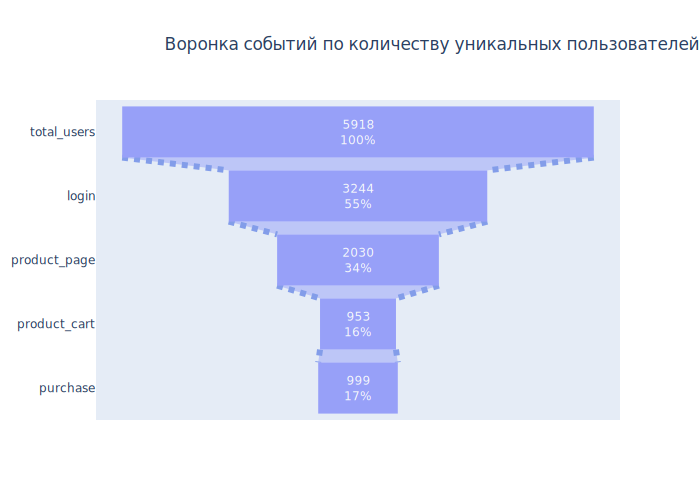

In [32]:
# строим воронку

labels = list(events['event_name'])
values = list(events['unique_users'])
order = [0, 1, 2, 4, 3]

fig = go.Figure(go.Funnel(
    y = [labels[i] for i in order],
    x = [values[i] for i in order],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.6,
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 6}})
    )


fig.update_layout(title = 'Воронка событий по количеству уникальных пользователей', title_x= .235)
fig.show()

- Воронка событий показывает всего **55%** конверсии в первое целевое событие от общего числа пользователей. При таком результате сложно быть уверенным в данных - такой результат может указывать на серьёзные технические проблемы при формировании лога пользовательских событий. В таком случае порядок действий может кардинально отличаться от пользователя к пользователю.

### Итоги

Исследовательский анализ был разделён на два шага:

- [**Анализ распределения данных**](#2.1)

- [**Воронка пользовательских событий**](#2.2)

В начале данные были собраны в единый датафрейм. При обзоре полученной таблицы были сделаны следующие выводы:

- Пользовательские события распределены неравномерно - на группу `A` приходится 15,558 событий, что составляет около **74%**.


- Самое позднее событие приходится на 30-12-2020, за несколько дней до официального завершения теста - возможна серьёзная ошибка в формировании лога пользовательских событий


- Столбцы с датой и названием события содержат пропуски - это коррелируют с выводом об отсутствии активности у части пользователей, сделанным во время обзора сырых данных

Вывод из анализа распределения данных:

- Распределение количества уникальных пользователей и событий ненормированно - 14-го декабря происходит аномальный скачок параметров, который достигает пика 21-го декабря, после чего происходит резкий спад. Фактической датой окончания теста можно считать 30-ое декабря - до официального прекращения проведения теста 4-го января в данных больше не наблюдается каких либо пользовательских событий. Аномальный скачок происходит в 01:30 14.12.2020, и касается только пользователей контрольной группы теста. В имеющихся данных отсутствуют рациональное объяснение для этого - в этот период не проводится никаких маркетинговых компаний, а даже если бы они были - влияние на пользователей было бы равным, но аномальному росту подвержены только пользователи группы `A`.

Вывод из анализа воронки событий:
    
- В целом последовательность событий упорядочена в схожем соотношении - `login` происходит чаще всего, `product_page` - примерно в два раза реже, и ещё в два раза реже остальные два события. Причём `purchase` часто равен или даже превышает `product_cart`, что лишний раз указывает на наличии и популярность опции по типу "покупка в один клик".


- Воронка событий показывает всего **55%** конверсии в первое целевое событие от общего числа пользователей. При таком результате сложно быть уверенным в данных - такой результат может указывать на серьёзные технические проблемы при формировании лога пользовательских событий. В таком случае порядок действий может кардинально отличаться от пользователя к пользователю.

<a id='3'></a>
## Оценка результатов A/B-тестирования

Для начала повторим воронку событий из предыдущего шага, но уже в разрезе групп эксперемента:

In [33]:
# посчитаем общий размер групп и количество событий

def uniq_gr(group):
    unq = (
        data[data['group'] == group]['user_id']
        .unique()
        .size
    )
    return pd.Series(
        ['total_users', group, unq],
        index=['event_name', 'group', 'unique_users']
    )

groups = [uniq_gr('A'), uniq_gr('B')]

# группируем данные, добавим итоги в таблицу

funn_df = (
    data
    .pivot_table(index=('event_name','group'), 
                 values='user_id',
                 aggfunc='nunique',
                )
    .rename(columns=dict(
        user_id='unique_users'))
    .reset_index()
    .append(groups, ignore_index=True)
    .sort_values('unique_users', ascending=False)
    .reset_index(drop=True)

)

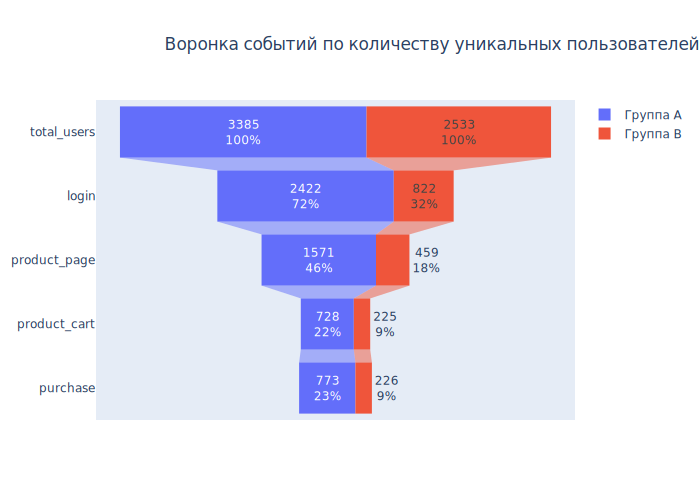

In [34]:
# строим воронку

def funn(group):
    
    labels = list(funn_df[funn_df['group'] == group]['event_name'])
    values = list(funn_df[funn_df['group'] == group]['unique_users'])
    order = [0, 1, 2, 4, 3]
    
    fig.add_trace(go.Funnel(
        name = 'Группа ' + group,
        y = [labels[i] for i in order],
        x = [values[i] for i in order],
        textinfo = "value+percent initial"))

fig = go.Figure()
   
for groups in ['A', 'B']:
    funn(groups) 

fig.update_layout(title = 'Воронка событий по количеству уникальных пользователей', title_x= .235)
fig.show()

- В воронке событий в разрезе групп теста отчётливо видно источник аномальных значений в данных - конверсия пользователей группы `B` в первое целевое действие составляет **32%**. В связи с этим распределение количества пользователей по событиям становиться несопоставивыми, что делает анализ результатов влияния новведений на пользовтельское поведение невозможным.

Несмотря на очевидную разницу распределения абсолютных значений в выборках теста, попробуем провести оценку статистической значимости различий.

Общие гипотезы для каждого шага:

**Нулевая гипотеза** - конверсии события от общего числа пользователей не имеют статистически значимую разницу

**Альтернативная гипотеза** - есть основания полагать, что конверсии отличаются.

Так как данные для расчёта статистической значимости являются долями, оптимальным инструментом станет **Z-критерий Фишера**:

In [35]:
# напишем функцию для проверки гипотез

def stat_check(successes_1, successes_2, trials_1, trials_2, alpha=.001): # поставим минимальный порог
    
    p1 = successes_1/trials_1
    p2 = successes_2/trials_2
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    difference = p1 - p2
    z_value = (
        difference / mth.sqrt(
            p_combined * (1 - p_combined) * (
                1/trials_1 + 1/trials_2))
    )

    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, данные выборки не имеют статистически значимой разницы ")  

In [36]:
# создадим необходимые для проверки переменные

# количество пользователей каждой группы

total = (
    funn_df
    .query('event_name == "total_users"')
    .sort_values('group')
    .reset_index(drop=True)
)

a_total = total.loc[0]['unique_users']
b_total = total.loc[1]['unique_users']

# список событий

events_list = (
    funn_df['event_name']
    .unique()
    .tolist()
)
del events_list[0]

# функция для получения значения группы для события

def get_val(group):
    val = int(
        funn_df.query(
            'event_name == @event and group == @group')
        ['unique_users'])
    return val

In [37]:
# запускаем цикл проверки для всех событий

for event in events_list:
    
    a = get_val('A')
    b = get_val('B')
    
    print(f'Проверка групп A и B в событии "{event}"')
    print()
    stat_check(a, b, a_total, b_total)
    print()

Проверка групп A и B в событии "login"

p-значение:  0.0
Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются

Проверка групп A и B в событии "product_page"

p-значение:  0.0
Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются

Проверка групп A и B в событии "purchase"

p-значение:  0.0
Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются

Проверка групп A и B в событии "product_cart"

p-значение:  0.0
Отвергаем нулевую гипотезу, есть основания полагать, что данные отличаются



- Статистическая проверка равенства долей конверсии каждого события показала нулевую вероятность, что подтверждает выводы из анализа воронки событий в разрезе групп теста.

<a id='4'></a>
##  Общий вывод

___
**Рекомендации**

- На всех этапах работы с данными прослеживаются технические проблемы - крупная часть пользователей попала в два разных A/B-теста, группы теста распределены неравномерно, треть пользователей не относиться к целевому региону. И даже в случае отсутствия всех вышеописанных моментов - одна из маркетинговых компаний должна была начаться за день до конца одного тестирования. Всё это указывает на серьезные нарушения при формировании групп тестирования, которые в итоге привели к невозможности оценки влияния новведений на пользовательское поведение, несмотря на тщательную предобработку - необходимо принять всевозможные меры по устранению этих недочётов на этапе дизайна теста.


- При проведении тестирования необходимо организовать промежуточную оценку результатов - графики показывают явные аномальные значения начиная с 14-го декабря, всего через неделю после начала теста. При должном промежуточном контроле тест можно было вовремя остановить и проанализировать возможные причины подобных проблем.


- В случае наличия критичных для конверсии пользовательских инструментов (например, "покупка в один клик") - эта информация должна быть указана в документации к тесте для корректного анализа результатов.

___

Целью исследования являлось проведение оценки результатов A/B-теста и корректности его проведения в соответствии с техническим заданием.

Данные были представлены в виде нескольких таблиц, содержащих список новых пользователей и информацию об их действиях, а также вспомогательную информацию - список участников всех тестов и календарь маркетинговых событий. Был проведён обзор и предобработка данных - обработаны дубликаты и пропуски, изменены типы данных. Также была проведена оценка коррекности проведения теста - данные были сверены с требованиями технического задания и календарём маркетинговых активностей. После был проведён исследовательский анализ данных, в ходе которого были изучены распределения данных и конверсия воронки событий, а последним этапом стал анализ результатов проведённого теста. По результатам исследования был сформирован общий вывод и рекомендации.

Таким образом, исследование было разделено на следующие этапы:

### [Обзор и предобработка данных](#1)

Данные всех четырёх таблиц были предобработаны - преобразованы даты, обработаны пропущенные значения. Было проверено соответствие данных техническому заданию A/B-тестирования.

При работе с данными были сделаны следующие выводы:

- Абсолютное большинство пользователей зарегестрировались в последний день рассматриваемого периода.


- В данных присутствуют пользователи из четырёх регионов, большая часть представляет регион `EU`


- Подавляющее больщинство пользователей используют устройство на базе `Android`


- Количество уникальных пользователей таблицы с пользовательскими событиями (*58,703*) не совпадает с количеством из таблицы со всеми новыми пользователями (*61,733*) - это указывает на то, что часть пользователей не совершали никаких активностей, что должно быть учтено при анализе результатов теста.


- Логи пользовательских событий содержат четыре уникальных значения - `login` (*вход в учётную запись*), `product_page` (*просмотр страницы с товаром*), `product_cart` (*просмотр страницы с корзиной товаров*) и `purchase` (*успешная покупка*). Причём количество событий с покупкой больше, чем количество просмотров корзины, что может сигнализировать об использовании модулей вроде `покупка в один клик`.


- Пользователи неравномерно распределены по группам - из 5,918 уникальных пользователей 3,385 находятся в группе `A`, что составляет примерно 57%.


- Целевой показатель количества участников в 6,000 формально был достигнут, но из-за пересечений с другим тестом часть данных не подлежит анализу, а их вынужденное удаление может негативно отразиться на выводах из анализа итоговых результатов. 


- Требование технического задания в формировании целовой аудитории теста из 15% пользователей из региона `EU` соблюдено, но в тест также попала часть пользователей из других регионов.


- Маркетинговая компании `Christmas&New Year Promo` пересекается с датами проведения A/B-тестирования, что может повлиять на пользовательское поведение и исказить вывода анализа результатов теста.

### [Иследовательский анализ данных](#2)

Исследовательский анализ был разделён на два шага:

- [**Анализ распределения данных**](#2.1)

- [**Воронка пользовательских событий**](#2.2)

В начале данные были собраны в единый датафрейм. При обзоре полученной таблицы были сделаны следующие выводы:

- Пользовательские события распределены неравномерно - на группу `A` приходится 15,558 событий, что составляет около **74%**.


- Самое позднее событие приходится на 30-12-2020, за несколько дней до официального завершения теста - возможна серьёзная ошибка в формировании лога пользовательских событий


- Столбцы с датой и названием события содержат пропуски - это коррелируют с выводом об отсутствии активности у части пользователей, сделанным во время обзора сырых данных

Вывод из анализа распределения данных:

- Распределение количества уникальных пользователей и событий ненормированно - 14-го декабря происходит аномальный скачок параметров, который достигает пика 21-го декабря, после чего происходит резкий спад. Фактической датой окончания теста можно считать 30-ое декабря - до официального прекращения проведения теста 4-го января в данных больше не наблюдается каких либо пользовательских событий. Аномальный скачок происходит в 01:30 14.12.2020, и касается только пользователей контрольной группы теста. В имеющихся данных отсутствуют рациональное объяснение для этого - в этот период не проводится никаких маркетинговых компаний, а даже если бы они были - влияние на пользователей было бы равным, но аномальному росту подвержены только пользователи группы `A`.

Вывод из анализа воронки событий:
    
- В целом последовательность событий упорядочена в схожем соотношении - `login` происходит чаще всего, `product_page` - примерно в два раза реже, и ещё в два раза реже остальные два события. Причём `purchase` часто равен или даже превышает `product_cart`, что лишний раз указывает на наличии и популярность опции по типу "покупка в один клик".


- Воронка событий показывает всего **55%** конверсии в первое целевое событие от общего числа пользователей. При таком результате сложно быть уверенным в данных - такой результат может указывать на серьёзные технические проблемы при формировании лога пользовательских событий. В таком случае порядок действий может кардинально отличаться от пользователя к пользователю.

### [Анализ результатов тестирования](#3)

- В воронке событий в разрезе групп теста отчётливо видно источник аномальных значений в данных - конверсия пользователей группы `B` в первое целевое действие составляет **32%**. В связи с этим распределение количества пользователей по событиям становиться несопоставивыми, что делает анализ результатов влияния новведений на пользовтельское поведение невозможным.

Несмотря на очевидную разницу распределения абсолютных значений в выборках теста, было принято решение провести оценку статистической значимости различий. Так как данные для расчёта статистической значимости являются долями, оптимальным инструментом стал **Z-критерий Фишера**.

- Статистическая проверка равенства долей конверсии каждого события показала нулевую вероятность, что подтверждает выводы из анализа воронки событий в разрезе групп теста.